# Milestone 1 - Understanding Sensor Data Errors

## Milestone 1.1 - Acceleration

In [1]:
# Import Statements
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.integrate import cumtrapz

In [2]:
# Load the data from the uploaded CSV file
file_path = os.path.join('lab8-dataset', 'ACCELERATION.csv')
data = pd.read_csv(file_path)

In [3]:
# Extracting acceleration and noisy acceleration data
acceleration = data['acceleration']
noisy_acceleration = data['noisyacceleration']
timestamp = data['timestamp']

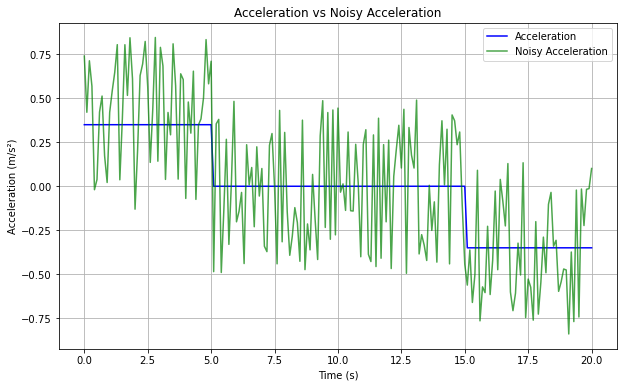

In [4]:
# Plotting both accelerations on the same graph with specified colors
plt.figure(figsize=(10, 6))
plt.plot(timestamp, acceleration, label='Acceleration', color='blue')
plt.plot(timestamp, noisy_acceleration, label='Noisy Acceleration', color='green', alpha=0.7)
plt.title('Acceleration vs Noisy Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

## Milestone 1.2 - Velocity

In [5]:
# Calculating speed by integrating acceleration using the trapezoidal rule
speed_actual = cumtrapz(acceleration, timestamp, initial=0)
speed_noisy = cumtrapz(noisy_acceleration, timestamp, initial=0)

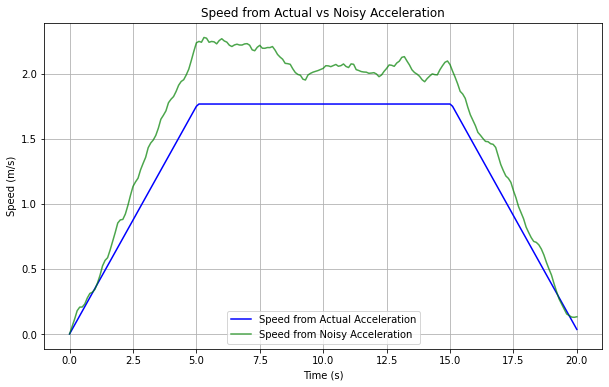

In [6]:
# Plotting both speeds on the same graph
plt.figure(figsize=(10, 6))
plt.plot(timestamp, speed_actual, label='Speed from Actual Acceleration', color='blue')
plt.plot(timestamp, speed_noisy, label='Speed from Noisy Acceleration', color='green', alpha=0.7)
plt.title('Speed from Actual vs Noisy Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()

## Milestone 1.3 - Distance

In [7]:
def calculate_cumulative_distance(acceleration, time):
    cumulative_distance = [0]
    initial_speed = 0  # Assuming the initial speed is zero

    for i in range(1, len(time)):
        delta_t = time[i] - time[i - 1]
        # Using the average acceleration over the interval
        avg_acceleration = (acceleration[i] + acceleration[i - 1]) / 2
        # Calculating displacement for this interval
        displacement = initial_speed * delta_t + 0.5 * avg_acceleration * delta_t**2
        # Updating the initial speed for the next interval
        initial_speed += avg_acceleration * delta_t
        # Adding the displacement for this interval to the cumulative distance
        cumulative_distance.append(cumulative_distance[-1] + displacement)

    return cumulative_distance

In [8]:
# Calculate cumulative distances
cumulative_distance_actual = calculate_cumulative_distance(acceleration, timestamp)
cumulative_distance_noisy = calculate_cumulative_distance(noisy_acceleration, timestamp)

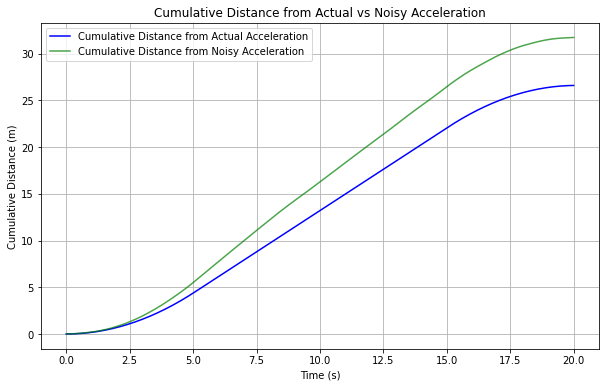

In [9]:
# Plotting cumulative distances over time
plt.figure(figsize=(10, 6))
plt.plot(timestamp, cumulative_distance_actual, label='Cumulative Distance from Actual Acceleration', color='blue')
plt.plot(timestamp, cumulative_distance_noisy, label='Cumulative Distance from Noisy Acceleration', color='green', alpha=0.7)
plt.title('Cumulative Distance from Actual vs Noisy Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Distance (m)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Get the total distances traveled and the difference
total_distance_actual = cumulative_distance_actual[-1]
total_distance_noisy = cumulative_distance_noisy[-1]
print("Total distance traveled using noisy acceleration:", total_distance_noisy, "meters")
print("Total distance traveled using actual acceleration:", total_distance_actual, "meters")
print("Difference between measurements:", total_distance_noisy - total_distance_actual , "meters")

Total distance traveled using noisy acceleration: 31.73405712893498 meters
Total distance traveled using actual acceleration: 26.59824999999999 meters
Difference between measurements: 5.135807128934992 meters


# Milestone 2 - Step Detection

## Milestone 2.1 - Data Preparation

In [19]:
# Load the data
file_path = os.path.join('lab8-dataset', 'WALKING.csv')
walking_data = pd.read_csv(file_path)
# Select the 'accel_z' column for step detection and apply a simple moving average for smoothing
window_size = 5  # Define the window size for the moving average
walking_data['accel_z_smoothed'] = walking_data['accel_z'].rolling(window=window_size).mean()

In [36]:
# Apply EWMA to the 'accel_z' column
span = 50  # Define the span for the EWMA
walking_data['accel_z_ewma'] = walking_data['accel_z'].ewm(span=span, adjust=False).mean()

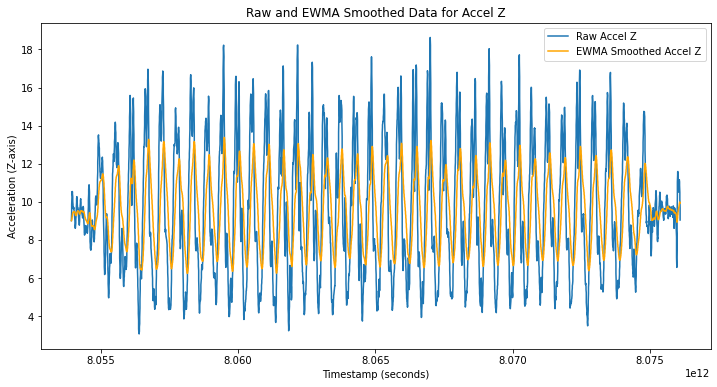

In [37]:
# Plotting the raw and smoothed data for the 'accel_z' component
plt.figure(figsize=(12, 6))
plt.plot(walking_data['timestamp'], walking_data['accel_z'], label='Raw Accel Z')
plt.plot(walking_data['timestamp'], walking_data['accel_z_ewma'], label='EWMA Smoothed Accel Z', color='orange')
plt.title('Raw and EWMA Smoothed Data for Accel Z')
plt.xlabel('Timestamp (seconds)')
plt.ylabel('Acceleration (Z-axis)')
plt.legend()
plt.show()

## Milestone 2.2 - Step Detection Algorithim

Number of steps detected: 37


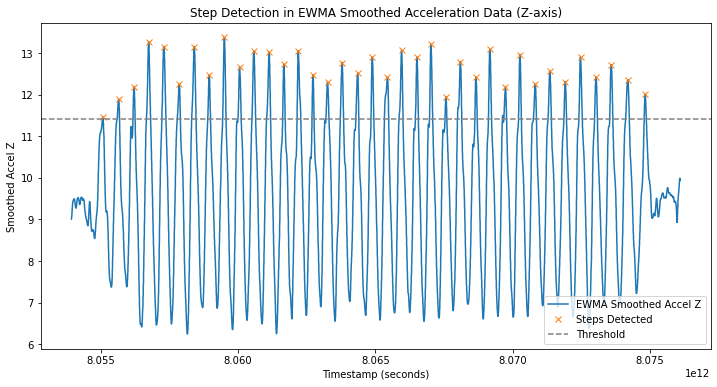

In [43]:
# Define the threshold and minimum distance between steps
threshold = walking_data['accel_z_ewma'].mean() + walking_data['accel_z_ewma'].std()
min_distance = 23  # This value may need to be adjusted

# Detect steps
steps_detected = []
last_step_index = -min_distance  # Initialize to a value that allows first peak to be detected

for i in range(1, len(walking_data) - 1):
    # Check if current point is a peak
    if walking_data['accel_z_ewma'].iloc[i] > walking_data['accel_z_ewma'].iloc[i - 1] and \
       walking_data['accel_z_ewma'].iloc[i] > walking_data['accel_z_ewma'].iloc[i + 1] and \
       walking_data['accel_z_ewma'].iloc[i] > threshold:
        # Check if peak is sufficiently far from the last detected peak
        if i - last_step_index >= min_distance:
            # Look-ahead mechanism: check for higher peak within min_distance
            upcoming_peaks = walking_data['accel_z_ewma'].iloc[i+1:i+min_distance].max()
            if walking_data['accel_z_ewma'].iloc[i] >= upcoming_peaks:
                steps_detected.append(i)
                last_step_index = i

# Number of detected steps
num_steps = len(steps_detected)
print(f'Number of steps detected: {num_steps}')

# Plot the smoothed data with detected steps
plt.figure(figsize=(12, 6))
plt.plot(walking_data['timestamp'], walking_data['accel_z_ewma'], label='EWMA Smoothed Accel Z')
plt.plot(walking_data['timestamp'][steps_detected], walking_data['accel_z_ewma'][steps_detected], 'x', label='Steps Detected')
plt.title('Step Detection in EWMA Smoothed Acceleration Data (Z-axis)')
plt.xlabel('Timestamp (seconds)')
plt.ylabel('Smoothed Accel Z')
plt.axhline(y=threshold, color='gray', linestyle='--', label='Threshold')
plt.legend(loc='lower right')
plt.show()

# Milsetone 3 - Direction Detection